In [222]:
import clean_data as cd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pipeline as p
import scipy.stats as scs
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploring the Dataset

In [210]:
df = pd.read_csv('Train.zip')
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Columns: 53 entries, SalesID to Steering_Controls
dtypes: float64(2), int64(6), object(45)
memory usage: 162.2+ MB


### Initial observations:
- Huge majority of features are mixed type, mainly strings and and floats
- Out of the 440K+ rows (purchases), many were missing 300K+ rows
- Some of the entries features that have full information (SalesID, MachineID, and ModelID hold very little information)

### Initial EDA:
As you can, see when inspecting the relationship between sales price and year sold, the model is highly heteroskedastic, which violates one of the basic assumptions of linear regression. 
The presence of so much categorical data also violates the assumption of the data being "linear and additive," which does make this data a poor fit for a linear regression. 

In [214]:
# split the data into independent and dependent variables
y = df.pop('SalePrice').values.reshape(-1,1)
X = df

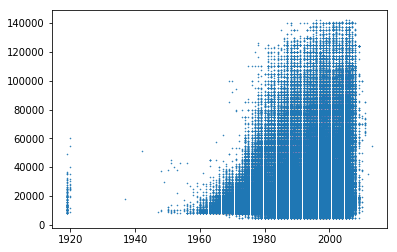

In [5]:
yr_made = np.array(df['YearMade'].loc[df['YearMade']>1900]).reshape(-1, 1)
y_df = pd.DataFrame(y)[df['YearMade']>1900]

plt.scatter(yr_made, y_df, s=.3);

### Data Cleaning
While a good technique would be to start with a few of the variables that appear most important and build the model off of those relationships, our group decided to use for our baseline analyses cross-validated, Lasso, Ridge, and simple OLS Linear Regression.
- To clean the data we started by dropping all columns with large amounts of incomplete values and deaggregated categorical variables with dummy variables
- See further details in clean_data.py

In [223]:
X_clean, y_clean, clean_df, X_test_final, df_test_final = cd.clean_data()

# First, our absolute baseline:
If the model only predicts the median sale price *every time*, what will our log-loss be?

In [7]:
scores_dict = {}
median_y = np.ones_like(y) * np.median(y)

# Scoring - log-loss comparing sale prices to the median
rmsle_score = np.sqrt(mean_squared_log_error(y, median_y))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['median'] = rmsle_score

RMSLE: 0.6938034164709894


In [224]:
X_train, X_test, y_train, y_test = p.data_split(X_clean, y_clean)

# Simple linear regression
Log-loss is shown below. The result is much worse than the median. Only up from here!

In [9]:
# cross-validated scores across 10-folds
cv_rmsle, cv_rmse = p.cv(X_train, y_train, 10, p.predict_lin_reg)

print('CV RMSLE: {}'.format(cv_rmsle))

CV RMSLE: 0.4909446127267561


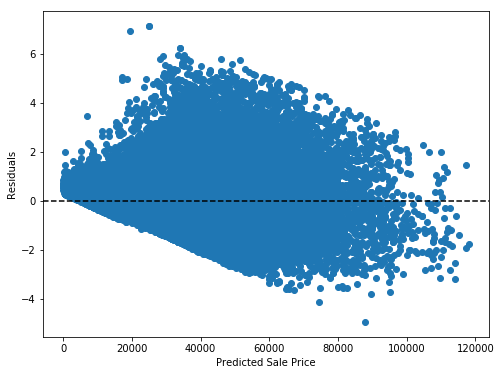

In [10]:
y_pred = p.predict_lin_reg(X_train, y_train, X_test)
y_pred[y_pred < 0] = 500
residuals = y_test - y_pred
stud_resid = residuals / np.std(residuals, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(y_pred, stud_resid)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('Residuals');

Based on the residuals plotted above, the data appears to be a poor fit for a linear model as the variance is not constant, or is heteroscedeastic.

In [11]:
f_statistic, p_value, _ = sm.stats.diagnostic.het_goldfeldquandt(
y_test, X_test, idx=1, alternative='two-sided')
print(p_value)

6.210634902794947e-187


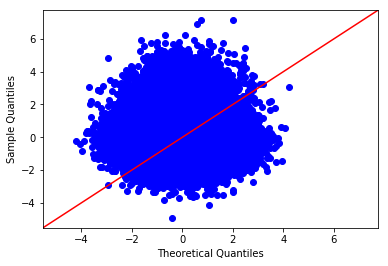

In [12]:
fig  = sm.graphics.qqplot(stud_resid, line='45')

The above Q-Q plot clearly shows that the residuals are not normally distributed, violating another assumption of linear regression.

In [13]:
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['linear unscaled'] = rmsle_score

RMSLE: 0.5126297742374516


# Linear regression scaled
Here I train the scaler to the training data and then use on the test data as well for cross-validation.

In [14]:
X_train_scaled, X_test_scaled, Xscaler = p.scale(X_train, X_test)
y_train_scaled, y_test_scaled, yscaler = p.scale(y_train, y_test)

In [15]:
# Scoring - log-loss comparing scaled sale prices to our scaled predictions
cv_scaled_rmsle, cv_scaled_rmse = p.cv(X_train_scaled, y_train_scaled, 10, p.predict_lin_reg)

print('CV RMSLE: {}'.format(cv_scaled_rmsle))

CV RMSLE: 0.22660005907121952


In [16]:
y_pred_scaled = p.predict_lin_reg(X_train_scaled, y_train_scaled, X_test_scaled)
residuals_scaled = y_test_scaled - y_pred_scaled
stud_resid_scaled = residuals_scaled / np.std(residuals_scaled, ddof=1)

In [17]:
f_statistic, p_value, _ = sm.stats.diagnostic.het_goldfeldquandt(
y_test_scaled, X_test_scaled, idx=1, alternative='two-sided')
print(p_value)

6.210634901505668e-187


The low p-value above means we reject the null hypothesis, that the residuals are homoscedastic.

In [18]:
# Unscale predictions
lin_preds_unscaled = yscaler.inverse_transform(y_pred_scaled.reshape(-1,1))
lin_preds_unscaled[lin_preds_unscaled < 0] = 500
rmsle_score = np.sqrt(mean_squared_log_error(y_test, lin_preds_unscaled))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['linear scaled'] = rmsle_score

RMSLE: 0.5119737390875863


### Next, we use Lasso and Ridge regressions with the scaled data.

# Ridge Regression

In [19]:
# Form predictions from scaled results
y_pred_ridge_scaled = p.ridge(X_train_scaled, y_train_scaled, X_test_scaled)

# Unscale predictions
ridge_preds_unscaled = np.concatenate((X_test[:,0].reshape(-1,1), yscaler.inverse_transform(y_pred_ridge_scaled.reshape(-1,1))), axis=1)
# Convert negative values to a positive value
ridge_preds_unscaled[ridge_preds_unscaled < 0] = 500

# Output results csv
df_output = pd.DataFrame(ridge_preds_unscaled, columns=['SalesID', 'SalePrice'])
df_output['SalesID'] = df_output['SalesID'].astype('int64')
df_output.to_csv('output_ridge.csv', index=False)

In [45]:
# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, ridge_preds_unscaled[:,1].reshape(-1,1)))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['ridge'] = rmsle_score

RMSLE: 0.5125587036258166


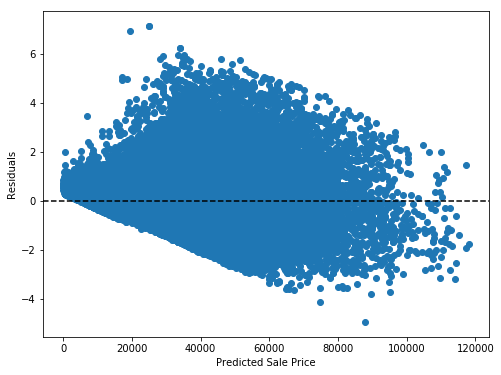

In [34]:
ridge_residuals = y_test - ridge_preds_unscaled[:,1].reshape(-1,1)
stud_resid_ridge = ridge_residuals / np.std(ridge_residuals, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(ridge_preds_unscaled[:,1].reshape(-1,1), stud_resid_ridge)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('Residuals');

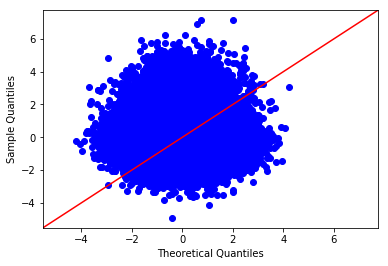

In [29]:
fig = sm.graphics.qqplot(stud_resid_ridge, line='45')

As you can see, a cross-validated and tuned ridge regression actually gave very similar predictions to a simple linear model.

# Lasso Regression

In [30]:
# Form predictions from scaled results
y_pred_lasso_scaled = p.lasso(X_train_scaled, y_train_scaled , X_test_scaled)

# Unscale predictions
lasso_preds_unscaled = np.concatenate((X_test[:,0].reshape(-1,1), yscaler.inverse_transform(y_pred_lasso_scaled.reshape(-1,1))), axis=1)
# Convert negative values to a positive value
lasso_preds_unscaled[lasso_preds_unscaled < 0] = 500

# Output results csv
df_output = pd.DataFrame(lasso_preds_unscaled, columns=['SalesID', 'SalePrice'])
df_output['SalesID'] = df_output['SalesID'].astype('int64')
df_output.to_csv('output_lasso.csv', index=False)

In [31]:
# Scoring - log-loss comparing sale prices to lasso predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, lasso_preds_unscaled[:,1].reshape(-1,1)))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['lasso'] = rmsle_score

RMSLE: 0.5468287895471287


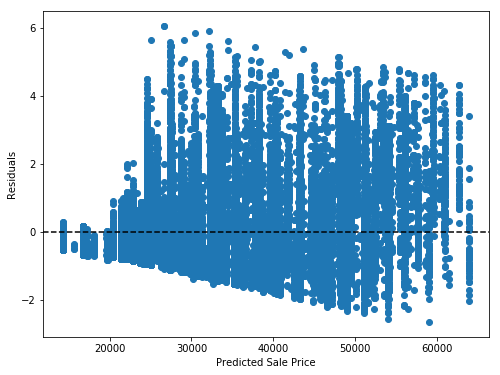

In [140]:
lasso_residuals = y_test - lasso_preds_unscaled[:,1].reshape(-1,1)
stud_resid_lasso = lasso_residuals / np.std(lasso_residuals, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(lasso_preds_unscaled[:,1], stud_resid_lasso)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('Residuals');

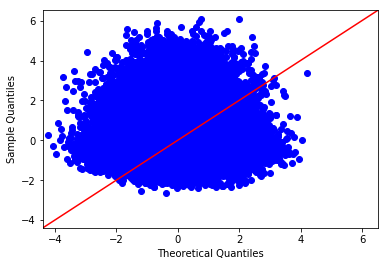

In [33]:
fig  = sm.graphics.qqplot(stud_resid_lasso, line='45')

# Random Forest

#### As this data set is not well suited towards a linear regression, let's try a Random Forest!

In [42]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

In [44]:
# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_predict_rf))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['RF'] = rmsle_score

RMSLE: 0.2995795877941926


##### - Tuning takes >60 minutes locally. Better to run on Spark.
param_grid = { 
    'n_estimators': [10, 20, 30, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}
##### - Run grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

### best tuned parameters are {'n_estimators': 100, 'max_features': 'auto'}

In [83]:
# tuned RF Regressor
rf_tuned = RandomForestRegressor(n_estimators= 100, max_features= 'auto')
rf_tuned.fit(X_train, y_train)
y_predict_tuned_rf = rf_tuned.predict(X_test)

# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_predict_tuned_rf))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['RF tuned'] = rmsle_score

RMSLE: 0.2904757870583415


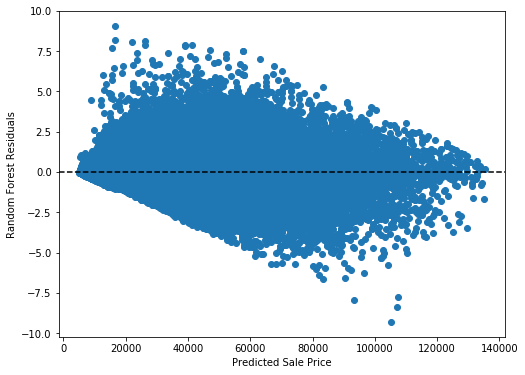

In [161]:
residuals_rf = y_test - y_predict_tuned_rf.reshape(-1,1)
stud_resid_rf = residuals_rf / np.std(residuals_rf, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(y_predict_tuned_rf.reshape(-1,1), stud_resid_rf)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('Random Forest Residuals');

# Recursive Feature Elimination

In [123]:
# Create the RFE object and rank each pixel
lr = LinearRegression(normalize=True)
lr.fit(X_clean, y_clean)

rfe = RFE(lr, n_features_to_select=1, step=1)
rfe = rfe.fit(X_clean, y_clean)
ranking = rfe.ranking_

In [124]:
zipped = zip(clean_df.columns[ranking-1], ranking)
sorted(zipped, key=lambda x: x[1])[:10]

[('SalesID', 1),
 ('YearMade', 2),
 ('datasource_121', 3),
 ('datasource_132', 4),
 ('datasource_149', 5),
 ('datasource_172', 6),
 ('UsageBand_High', 7),
 ('UsageBand_Low', 8),
 ('UsageBand_Medium', 9),
 ('ProductSize_Compact', 10)]

As we can see, SalesID must capture some amount of signal. Below, we will fit a linear regression only to our SalesID columns and plot our residuals.

### SalesID

In [157]:
lr = LinearRegression(normalize=True)
lr.fit(X_train[:,0].reshape(-1,1), y_train.reshape(-1,1))
y_salesid_pred = lr.predict(X_test[:,0].reshape(-1,1))

# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_salesid_pred))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['SalesID alone'] = rmsle_score

RMSLE: 0.7348311950471176


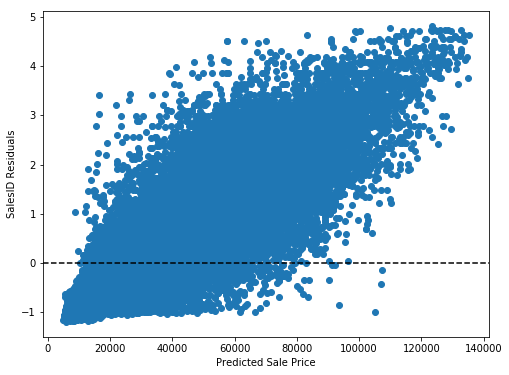

In [162]:
residuals_ID = y_test - y_salesid_pred.reshape(-1,1)
stud_resid_ID = residuals_ID / np.std(residuals_ID, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(y_predict_tuned_rf.reshape(-1,1), stud_resid_ID)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('SalesID Residuals');

Now, let's take a quick look at YearMade.

### YearMade

In [171]:
lr = LinearRegression(normalize=True)
lr.fit(X_train[:,1].reshape(-1,1), y_train.reshape(-1,1))
y_ym_pred = lr.predict(X_test[:,1].reshape(-1,1))

# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_ym_pred))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['YearMade alone'] = rmsle_score

RMSLE: 0.7212266698065048


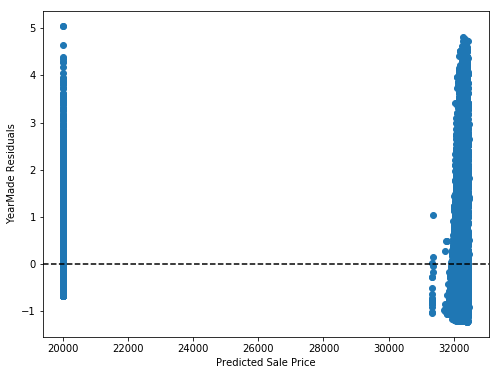

In [168]:
residuals_ym = y_test - y_ym_pred.reshape(-1,1)
stud_resid_ym = residuals_ym / np.std(residuals_ym, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(y_ym_pred.reshape(-1,1), stud_resid_ym)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('YearMade Residuals');

### Both Sales ID and YearMade

In [200]:
lr = LinearRegression(normalize=True)
lr.fit(X_train[:,0:2], y_train.reshape(-1,1))
y_ymID_pred = lr.predict(X_test[:,0:2])

# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, y_ymID_pred))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['YearMade and ID'] = rmsle_score

RMSLE: 0.7212931144236354


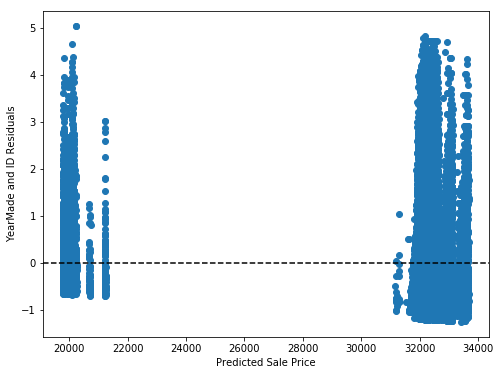

In [201]:
residuals_ymID = y_test - y_ymID_pred.reshape(-1,1)
stud_resid_ymID = residuals_ymID / np.std(residuals_ymID, ddof=1)

fig, ax = plt.subplots(1,1, figsize = (8,6))

ax.scatter(y_ymID_pred.reshape(-1,1), stud_resid_ymID)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel('Predicted Sale Price')
ax.set_ylabel('YearMade and ID Residuals');

# But... what if we just groupby Model ID instead?

In this method, we simply group by vehicle model ID and set each vehicle's predicted price by the average of their sold prices for their model IDs. And if the model ID is only in the test set, not in the training set, we just set the prediction to be the average price.

In [271]:
df = pd.read_csv('Train.zip')
# preds by modelID alone
modelID_preds = df.groupby('ModelID')['SalePrice'].agg(np.mean)

In [274]:
X_train, X_test, y_train, y_test = train_test_split(df['ModelID'], y, test_size=0.33, random_state=42)
y_mean = np.mean(y)
modelIDs_X_test = pd.Series.to_frame(X_test)
modelIDs_predictions = modelIDs_X_test['ModelID'].apply(lambda x: modelID_preds[int(x)] if x in modelID_preds.index else y_mean)



In [275]:
# Scoring - log-loss comparing sale prices to ridge predictions
rmsle_score = np.sqrt(mean_squared_log_error(y_test, modelIDs_predictions))

print('RMSLE: {}'.format(rmsle_score))
scores_dict['Groupby on ModelID alone'] = rmsle_score

RMSLE: 0.32174778352923217


Amazingly, this is one of our best scores!!

# Analysis

In [277]:
sorted_by_value = sorted(scores_dict.items(), key=lambda kv: kv[1])
sorted_by_value

[('RF tuned', 0.2904757870583415),
 ('RF', 0.2995795877941926),
 ('Groupby on ModelID alone', 0.32174778352923217),
 ('linear scaled', 0.5119737390875863),
 ('ridge', 0.5125587036258166),
 ('linear unscaled', 0.5126297742374516),
 ('lasso', 0.5468287895471287),
 ('median', 0.6938034164709894),
 ('YearMade alone', 0.7212266698065048),
 ('YearMade and ID', 0.7212931144236354),
 ('SalesID alone', 0.7348311950471176)]

As we saw again and again, this data was extremeley poorly suited for linear regression, and feature alone gave enough signal to beat choosing the median every time. Luckily, linear, ridge, and lasso regressions were able to find signal across all of the features and produce decent results. 

While this dataset was clearly better suited for analysis by non-linear models due to multicollinearity and heteroskedasticy, I think it is worth noting that by simply grouping on ModelID, we were able to nearly as good results!

The takeaway here is that clever feature engineering is an essential ingredient for creating high-performing models.